# Exploring Oura ring data with Calendar Data

## Load calendar events from file

In [1]:
import ics
import pandas as pd

def event_to_dict(event):
    return {
        'name': event.name,
        'begin': event.begin.date().strftime('%Y-%m-%d'),
        'duration_hours': event.duration.seconds / 3600,
    }

# Note: Sample just contains a bit of events, not really enough for good correlations
with open('sample_calendar.ics','r') as f:
    icsFile = ics.Calendar(f.read())
    events = [event_to_dict(event) for event in icsFile.events]
    #print(events)


In [2]:
df_calendar = pd.DataFrame(events)
df_calendar['begin'] = pd.to_datetime(df_calendar['begin']).dt.normalize()

# Filter out old events (if necessary)
#df_calendar = df_calendar.loc[df_calendar['begin'] >= '2022-01-01']

# Filter out future events
df_calendar = df_calendar.loc[df_calendar['begin'] <= pd.Timestamp.today()]

# Filter in only actual 'busy' events, not 'tentative', and duration > 0 and duration <= 8h
df_calendar = df_calendar.loc[(df_calendar['name'] == 'Busy') & (df_calendar['duration_hours'] > 0) & (df_calendar['duration_hours'] <= 8)]

df_calendar.info()
df_calendar.head()





<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 2 to 317
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            143 non-null    object        
 1   begin           143 non-null    datetime64[ns]
 2   duration_hours  143 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.5+ KB


,name,begin,duration_hours
2,Busy,2021-05-21,0.833333
7,Busy,2021-03-25,1.000000
10,Busy,2021-04-09,1.000000
11,Busy,2021-08-20,1.000000
13,Busy,2022-01-24,0.833333


In [3]:
df_calendar = df_calendar.groupby('begin')['duration_hours'].agg(duration_sum='sum', meetings_count='count').reset_index()

df_calendar = df_calendar.set_index('begin', inplace=False)
df_calendar.info()
df_calendar.head()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78 entries, 2021-01-28 to 2022-01-25
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   duration_sum    78 non-null     float64
 1   meetings_count  78 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 1.8 KB


,duration_sum,meetings_count
begin,,
2021-01-28,1.0,1
2021-01-29,1.0,1
2021-02-02,1.0,1
2021-02-04,4.0,2
2021-02-12,2.5,3


In [4]:
#%pip install pandas mlplot
 
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter

def grab_oura_json(file_path):    
    with open(file_path) as activities_file:
        data = json.load(activities_file)
        return data

file_path = 'data/oura_activities.json'
data = grab_oura_json(file_path)
# activity, notes, readiness, restful_periods, sleep    
df_sleep = pd.DataFrame.from_dict(data['sleep'])
#df_sleep.info()
#df_sleep.head()
#df_sleep.describe()
#df_sleep['bedtime_end']

# Reindex by bedtime end date
df_sleep['datetime'] = pd.to_datetime(df_sleep['bedtime_end'], utc=True).dt.normalize()
df_sleep['weekday'] = df_sleep['datetime'].dt.dayofweek
df_sleep['weekend'] = (df_sleep['datetime'].dt.dayofweek > 4).astype(int)
df_sleep['datetime_naive'] = df_sleep['datetime'].apply(lambda t: t.replace(tzinfo=None))
df_sleep = df_sleep.set_index('datetime_naive', inplace=False)
df_sleep.info()
df_sleep.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 471 entries, 2020-08-19 to 2022-01-07
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   awake                        471 non-null    int64              
 1   bedtime_end                  471 non-null    object             
 2   bedtime_end_delta            471 non-null    int64              
 3   bedtime_start                471 non-null    object             
 4   bedtime_start_delta          471 non-null    int64              
 5   breath_average               471 non-null    float64            
 6   deep                         471 non-null    int64              
 7   duration                     471 non-null    int64              
 8   efficiency                   471 non-null    int64              
 9   hr_5min                      471 non-null    object             
 10  hr_average                   47

,awake,bedtime_end,bedtime_end_delta,bedtime_start,bedtime_start_delta,breath_average,deep,duration,efficiency,hr_5min,...,score_total,summary_date,temperature_delta,temperature_deviation,timezone,total,temperature_trend_deviation,datetime,weekday,weekend
datetime_naive,,,,,,,,,,,,,,,,,,,,,
2020-08-19,1710,2020-08-19T06:00:34+03:00,21634,2020-08-19T00:09:34+03:00,574,14.125,3720,21060,92,"[64, 67, 67, 66, 65, 66, 67, 67, 67, 67, 67, 6...",...,53,2020-08-19,-0.24,-0.24,180,19350,NaN,2020-08-19 00:00:00+00:00,2,0
2020-08-20,2370,2020-08-20T06:00:28+03:00,21628,2020-08-19T23:16:28+03:00,-2612,14.375,5280,24240,90,"[0, 64, 67, 68, 68, 71, 72, 73, 71, 68, 67, 66...",...,64,2020-08-20,-0.05,-0.05,180,21870,0.09,2020-08-20 00:00:00+00:00,3,0
2020-08-21,2250,2020-08-21T06:00:55+03:00,21655,2020-08-21T00:00:55+03:00,55,14.500,4740,21600,90,"[0, 76, 74, 73, 70, 70, 69, 68, 68, 67, 67, 71...",...,53,2020-08-21,-0.05,-0.05,180,19350,0.11,2020-08-21 00:00:00+00:00,4,0
2020-08-22,3810,2020-08-22T07:35:34+03:00,27334,2020-08-21T23:03:34+03:00,-3386,14.750,6360,30720,88,"[79, 83, 84, 83, 83, 84, 84, 84, 83, 77, 73, 7...",...,85,2020-08-22,0.19,0.19,180,26910,0.25,2020-08-22 00:00:00+00:00,5,1
2020-08-23,3030,2020-08-23T07:33:03+03:00,27183,2020-08-22T23:52:03+03:00,-477,15.250,5220,27660,89,"[0, 0, 80, 79, 77, 77, 76, 71, 72, 74, 75, 75,...",...,75,2020-08-23,-0.12,-0.12,180,24630,0.24,2020-08-23 00:00:00+00:00,6,1


In [5]:
# Shift oura events one day back, so they match with calendar events
df_calendar = df_calendar.shift(periods=1, axis=0, fill_value=0) # Shift onwards by one so they match the sleep date
df = df_sleep.join(df_calendar) # Join calendar events to oura events
df.head()

# Populate NaN values for days when there was no meetings
df['duration_sum'] = df['duration_sum'].fillna(0)
df['meetings_count'] = df['meetings_count'].fillna(0)
# Drop non-numerical column to make it neater, but use full range of data
df = df.drop('is_longest', axis=1) 
df = df.drop('timezone', axis=1) 



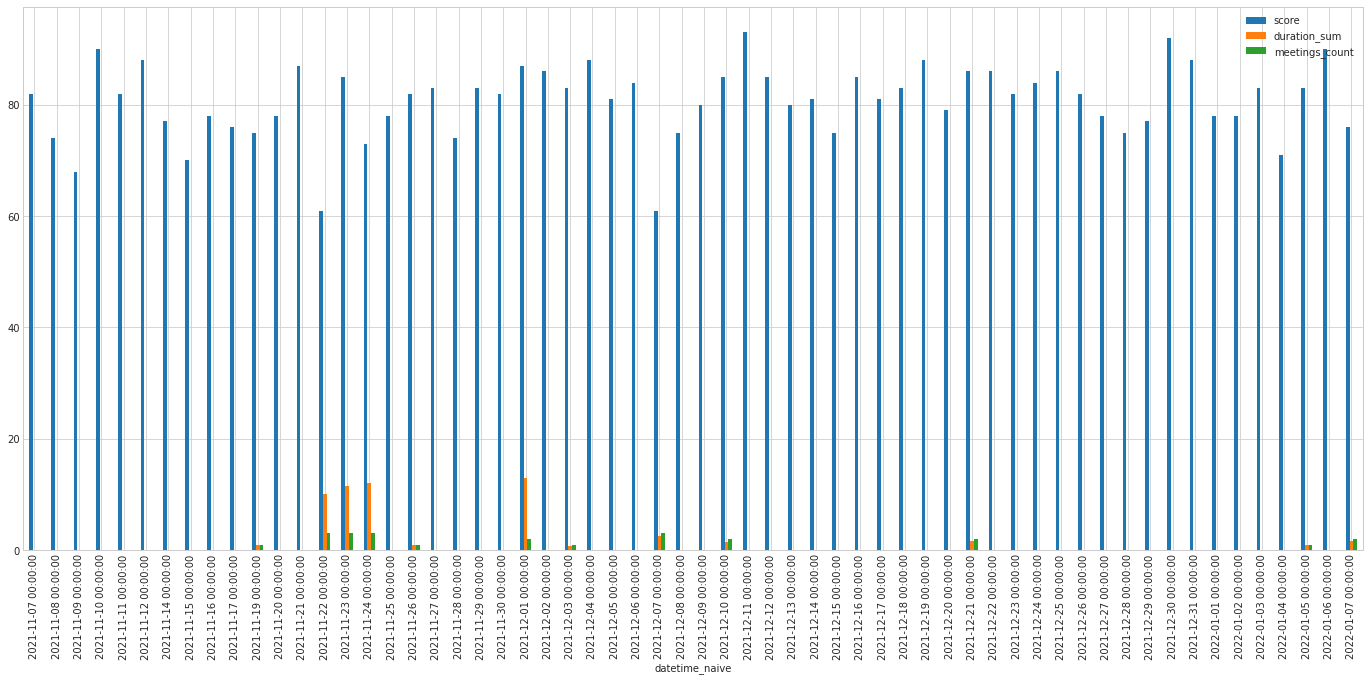

In [6]:
plt.style.use('seaborn-whitegrid')

# Snip to last 60 days of data
df = df.tail(60)

ax = df.plot(use_index=True, y=["score","duration_sum","meetings_count"], kind="bar",  figsize=(24,10))

plt.show()

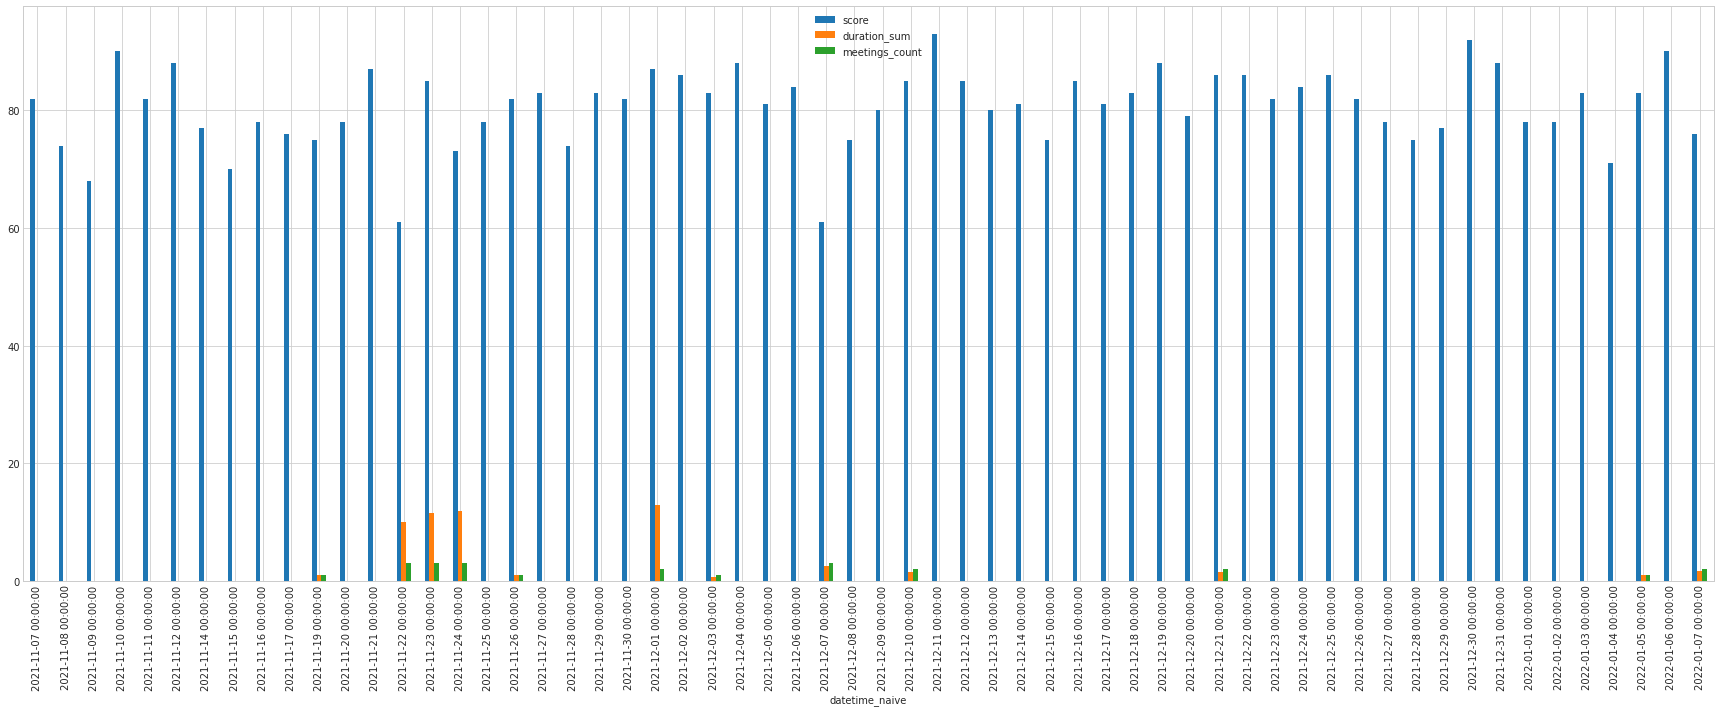

In [21]:
fig, ax = plt.subplots(figsize=(24,10))
ax = df.plot(use_index=True, y=["score","duration_sum","meetings_count"], kind="bar",  figsize=(24,10), ax=ax)
fig.tight_layout()
plt.show()

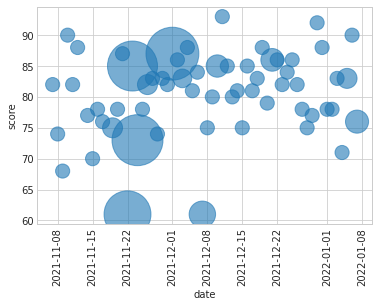

In [9]:
#plt.scatter(df.index, df.score, s=(df.duration_sum + 1) * 200, alpha=0.6)
plt.scatter(df.index, df.score, s=(df.meetings_count + 1) * 200, alpha=0.6)
plt.xlabel('date')
plt.ylabel('score')
plt.xticks(rotation=90)
plt.show()

In [10]:
# Just use data for 30 last days
#df = df.tail(30)


corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_8150/3838441770.py:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,awake,bedtime_end_delta,bedtime_start_delta,breath_average,deep,duration,efficiency,hr_average,hr_lowest,light,midpoint_at_delta,midpoint_time,onset_latency,period_id,rem,restless,rmssd,score,score_alignment,score_deep,score_disturbances,score_efficiency,score_latency,score_rem,score_total,temperature_delta,temperature_deviation,total,temperature_trend_deviation,weekday,weekend,duration_sum,meetings_count
awake,1.00,0.40,-0.09,0.14,-0.10,0.44,-0.92,0.35,0.20,0.29,0.30,0.52,0.11,-0.03,0.03,0.17,-0.02,-0.15,-0.30,-0.21,-0.44,-0.89,0.16,-0.05,0.15,0.30,0.30,0.18,0.12,0.18,0.35,-0.09,-0.16
bedtime_end_delta,0.40,1.00,0.30,0.02,0.05,0.73,-0.15,0.41,0.31,0.50,0.87,0.73,-0.20,0.20,0.62,-0.05,-0.22,0.26,-0.87,0.01,-0.10,-0.12,-0.02,0.40,0.68,0.12,0.12,0.68,-0.03,0.64,0.82,-0.22,-0.31
bedtime_start_delta,-0.09,0.30,1.00,0.04,-0.02,-0.43,-0.08,0.21,0.27,-0.41,0.72,-0.41,0.00,0.01,-0.31,0.02,-0.08,-0.66,-0.70,-0.03,-0.15,-0.08,-0.11,-0.36,-0.40,-0.18,-0.18,-0.44,-0.19,0.11,0.27,0.01,0.13
breath_average,0.14,0.02,0.04,1.00,-0.11,-0.01,-0.15,0.48,0.36,0.02,0.06,0.03,0.04,-0.15,-0.04,-0.01,-0.42,-0.09,-0.06,-0.09,0.03,-0.20,-0.02,0.03,-0.07,0.59,0.59,-0.05,0.49,-0.07,0.06,0.05,0.03
deep,-0.10,0.05,-0.02,-0.11,1.00,0.05,0.16,-0.06,-0.08,-0.50,-0.00,0.02,-0.13,-0.15,0.00,-0.04,0.43,0.17,-0.00,0.70,-0.02,0.17,-0.13,0.07,0.14,-0.10,-0.10,0.09,-0.01,0.06,0.00,0.26,0.11
duration,0.44,0.73,-0.43,-0.01,0.05,1.00,-0.09,0.24,0.11,0.77,0.31,0.99,-0.19,0.18,0.81,-0.06,-0.15,0.71,-0.33,0.03,0.01,-0.06,0.06,0.64,0.92,0.24,0.24,0.96,0.11,0.52,0.59,-0.21,-0.39
efficiency,-0.92,-0.15,-0.08,-0.15,0.16,-0.09,1.00,-0.26,-0.18,-0.03,-0.22,-0.18,-0.22,0.08,0.28,-0.22,-0.01,0.47,0.21,0.27,0.53,0.96,-0.17,0.35,0.21,-0.24,-0.24,0.18,-0.10,0.02,-0.15,-0.00,0.00
hr_average,0.35,0.41,0.21,0.48,-0.06,0.24,-0.26,1.00,0.87,0.18,0.44,0.29,0.06,-0.05,0.10,-0.19,-0.53,-0.03,-0.44,-0.19,0.09,-0.32,-0.11,0.11,0.19,0.54,0.54,0.15,0.21,0.27,0.41,-0.12,-0.09
hr_lowest,0.20,0.31,0.27,0.36,-0.08,0.11,-0.18,0.87,1.00,0.10,0.39,0.15,0.11,0.04,0.03,-0.14,-0.51,-0.12,-0.38,-0.28,0.08,-0.22,-0.12,-0.01,0.08,0.41,0.41,0.05,0.11,0.20,0.33,-0.18,-0.11
light,0.29,0.50,-0.41,0.02,-0.50,0.77,-0.03,0.18,0.10,1.00,0.16,0.76,-0.08,0.20,0.54,-0.01,-0.31,0.53,-0.17,-0.36,0.07,-0.02,0.11,0.40,0.68,0.32,0.32,0.75,0.17,0.36,0.45,-0.31,-0.41
